In [1]:
import os
import tarfile
import random
import shutil
import urllib.request # to download the dataset
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

## Data Preparation

In [2]:
# -----------------------------
# STEP 1: DOWNLOAD DATA
# -----------------------------
def download_and_extract(url, filename, extract_path):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
    if not os.path.exists(extract_path):
        print(f"Extracting {filename}...")
        with tarfile.open(filename) as tar:
            tar.extractall(path=extract_path)

download_and_extract(
    "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar",
    "images.tar",
    "stanford_dogs"
)

Extracting images.tar...


In [3]:
# -----------------------------
# STEP 2: PARSE DATA & STRATIFIED SPLIT
# -----------------------------
all_images = []
labels = []
label_map = {}
label_index = 0

# Constants
image_limit = 15000 # limit the set size for local performance reasons
random_state_value = 42

image_root = "stanford_dogs/Images"
for breed_folder in os.listdir(image_root):
    folder_path = os.path.join(image_root, breed_folder)
    if os.path.isdir(folder_path):
        if breed_folder not in label_map:
            label_map[breed_folder] = label_index
            label_index += 1

        images = os.listdir(folder_path)
        for img in images:
            all_images.append(os.path.join(folder_path, img))
            labels.append(label_map[breed_folder])

# STRATIFIED SAMPLING
#_, temp_images, _, temp_labels = train_test_split(
#    all_images, labels, stratify=labels, test_size=image_limit, random_state=random_state_value)

#train_images, val_images, train_labels, val_labels = train_test_split(
 #   temp_images, temp_labels, stratify=temp_labels, test_size=0.2, random_state=random_state_value)

train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, labels, stratify=labels, test_size=0.2, random_state=42)

In [4]:
# -----------------------------
# STEP 3: ORGANIZE INTO FOLDERS
# -----------------------------
def organize_dataset(images, labels, output_dir):
    for img_path, label in zip(images, labels):
        breed = os.path.basename(os.path.dirname(img_path))
        dest_dir = os.path.join(output_dir, breed)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(dest_dir, os.path.basename(img_path)))

if os.path.exists("data"): shutil.rmtree("data")
organize_dataset(train_images, train_labels, "data/train")
organize_dataset(val_images, val_labels, "data/val")

In [5]:
# -----------------------------
# STEP 4: SETUP DATA LOADERS
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("data/train", transform=transform)
val_dataset = datasets.ImageFolder("data/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Model

In [6]:
# -----------------------------
# STEP 5: MODEL
# -----------------------------
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for name, param in model.named_parameters(): # Fine tuning
    if "layer4" in name or "fc" in name:
        param.requires_grad = True


model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


## Training

In [7]:
# -----------------------------
# STEP 6: TRAINING LOOP
# -----------------------------
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=40):

    best_val_acc = 0
    patience = 5
    patience_counter = 0 

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = 100 * correct / len(train_loader.dataset)
        train_losses.append(total_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        correct_top1 = 0
        correct_top5 = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # Top-1
                _, top1_preds = outputs.topk(1, dim=1)
                correct_top1 += (top1_preds.squeeze() == labels).sum().item()
                # Top-5
                _, top5_preds = outputs.topk(5, dim=1)
                correct_top5 += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])


        val_top1_acc = 100 * correct_top1 / len(val_loader.dataset)
        val_top5_acc = 100 * correct_top5 / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_top1_acc)

        if val_top1_acc > best_val_acc:
          best_val_acc = val_top1_acc
          patience_counter = 0
          torch.save(model.state_dict(), "/kaggle/working/best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break
        
        print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}")
        print(f"Val Acc Top-1: {val_top1_acc:.2f}%, Top-5: {val_top5_acc:.2f}%")
        scheduler.step()

In [8]:
train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/40: 100%|██████████| 515/515 [01:44<00:00,  4.94it/s]


Epoch 1, Train Loss: 1364.0466, Train Acc: 36.63%, Val Loss: 166.6379
Val Acc Top-1: 67.01%, Top-5: 92.86%


Epoch 2/40: 100%|██████████| 515/515 [01:44<00:00,  4.95it/s]


Epoch 2, Train Loss: 786.8152, Train Acc: 57.88%, Val Loss: 130.3705
Val Acc Top-1: 71.70%, Top-5: 94.29%


Epoch 3/40: 100%|██████████| 515/515 [01:43<00:00,  4.97it/s]


Epoch 3, Train Loss: 694.7700, Train Acc: 61.21%, Val Loss: 123.6646
Val Acc Top-1: 72.30%, Top-5: 94.39%


Epoch 4/40: 100%|██████████| 515/515 [01:43<00:00,  4.97it/s]


Epoch 4, Train Loss: 653.9112, Train Acc: 63.28%, Val Loss: 116.2195
Val Acc Top-1: 72.59%, Top-5: 94.66%


Epoch 5/40: 100%|██████████| 515/515 [01:43<00:00,  4.97it/s]


Epoch 5, Train Loss: 634.9256, Train Acc: 63.94%, Val Loss: 112.6357
Val Acc Top-1: 73.71%, Top-5: 94.85%


Epoch 6/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 6, Train Loss: 625.6009, Train Acc: 64.36%, Val Loss: 111.4357
Val Acc Top-1: 73.20%, Top-5: 95.14%


Epoch 7/40: 100%|██████████| 515/515 [01:43<00:00,  4.96it/s]


Epoch 7, Train Loss: 614.4263, Train Acc: 64.91%, Val Loss: 109.4378
Val Acc Top-1: 73.64%, Top-5: 95.31%


Epoch 8/40: 100%|██████████| 515/515 [01:44<00:00,  4.95it/s]


Epoch 8, Train Loss: 612.5076, Train Acc: 65.12%, Val Loss: 108.9983
Val Acc Top-1: 74.10%, Top-5: 95.29%


Epoch 9/40: 100%|██████████| 515/515 [01:44<00:00,  4.92it/s]


Epoch 9, Train Loss: 601.0149, Train Acc: 65.65%, Val Loss: 110.9044
Val Acc Top-1: 73.91%, Top-5: 95.09%


Epoch 10/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 10, Train Loss: 602.6555, Train Acc: 65.77%, Val Loss: 110.5920
Val Acc Top-1: 73.62%, Top-5: 94.92%


Epoch 11/40: 100%|██████████| 515/515 [01:43<00:00,  5.00it/s]


Epoch 11, Train Loss: 551.9150, Train Acc: 67.71%, Val Loss: 101.6027
Val Acc Top-1: 76.31%, Top-5: 95.63%


Epoch 12/40: 100%|██████████| 515/515 [01:43<00:00,  4.95it/s]


Epoch 12, Train Loss: 540.0981, Train Acc: 69.11%, Val Loss: 99.9348
Val Acc Top-1: 76.29%, Top-5: 95.53%


Epoch 13/40: 100%|██████████| 515/515 [01:43<00:00,  4.97it/s]


Epoch 13, Train Loss: 535.8381, Train Acc: 68.79%, Val Loss: 99.1691
Val Acc Top-1: 76.48%, Top-5: 95.65%


Epoch 14/40: 100%|██████████| 515/515 [01:43<00:00,  4.97it/s]


Epoch 14, Train Loss: 533.2465, Train Acc: 68.93%, Val Loss: 99.7386
Val Acc Top-1: 76.60%, Top-5: 95.65%


Epoch 15/40: 100%|██████████| 515/515 [01:43<00:00,  4.96it/s]


Epoch 15, Train Loss: 538.2330, Train Acc: 68.58%, Val Loss: 99.3112
Val Acc Top-1: 76.51%, Top-5: 95.87%


Epoch 16/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 16, Train Loss: 528.1518, Train Acc: 69.36%, Val Loss: 99.8608
Val Acc Top-1: 76.29%, Top-5: 95.68%


Epoch 17/40: 100%|██████████| 515/515 [01:43<00:00,  4.99it/s]


Epoch 17, Train Loss: 527.4924, Train Acc: 69.03%, Val Loss: 99.3498
Val Acc Top-1: 76.41%, Top-5: 95.68%


Epoch 18/40: 100%|██████████| 515/515 [01:43<00:00,  4.97it/s]


Epoch 18, Train Loss: 524.6272, Train Acc: 69.23%, Val Loss: 97.9754
Val Acc Top-1: 76.75%, Top-5: 95.80%


Epoch 19/40: 100%|██████████| 515/515 [01:43<00:00,  4.99it/s]


Epoch 19, Train Loss: 527.6624, Train Acc: 69.52%, Val Loss: 98.6913
Val Acc Top-1: 76.72%, Top-5: 95.63%


Epoch 20/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 20, Train Loss: 526.9533, Train Acc: 69.08%, Val Loss: 98.7373
Val Acc Top-1: 76.75%, Top-5: 95.63%


Epoch 21/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 21, Train Loss: 516.6705, Train Acc: 69.45%, Val Loss: 97.5221
Val Acc Top-1: 77.11%, Top-5: 95.77%


Epoch 22/40: 100%|██████████| 515/515 [01:43<00:00,  4.99it/s]


Epoch 22, Train Loss: 517.3675, Train Acc: 69.99%, Val Loss: 98.4553
Val Acc Top-1: 76.94%, Top-5: 95.75%


Epoch 23/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 23, Train Loss: 509.4004, Train Acc: 70.49%, Val Loss: 98.0049
Val Acc Top-1: 76.77%, Top-5: 95.63%


Epoch 24/40: 100%|██████████| 515/515 [01:43<00:00,  4.97it/s]


Epoch 24, Train Loss: 511.8353, Train Acc: 70.14%, Val Loss: 98.4021
Val Acc Top-1: 76.53%, Top-5: 95.65%


Epoch 25/40: 100%|██████████| 515/515 [01:44<00:00,  4.95it/s]


Epoch 25, Train Loss: 518.1147, Train Acc: 69.73%, Val Loss: 97.5787
Val Acc Top-1: 77.14%, Top-5: 95.82%


Epoch 26/40: 100%|██████████| 515/515 [01:44<00:00,  4.94it/s]


Epoch 26, Train Loss: 515.2963, Train Acc: 69.85%, Val Loss: 98.3920
Val Acc Top-1: 76.82%, Top-5: 95.55%


Epoch 27/40: 100%|██████████| 515/515 [01:43<00:00,  4.99it/s]


Epoch 27, Train Loss: 514.9597, Train Acc: 69.94%, Val Loss: 97.8149
Val Acc Top-1: 76.85%, Top-5: 95.82%


Epoch 28/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 28, Train Loss: 512.6773, Train Acc: 69.91%, Val Loss: 98.2637
Val Acc Top-1: 76.82%, Top-5: 95.58%


Epoch 29/40: 100%|██████████| 515/515 [01:43<00:00,  4.98it/s]


Epoch 29, Train Loss: 520.9509, Train Acc: 69.65%, Val Loss: 98.2814
Val Acc Top-1: 76.72%, Top-5: 95.68%


Epoch 30/40: 100%|██████████| 515/515 [01:43<00:00,  4.96it/s]


Early stopping!


In [9]:
torch.save(model.state_dict(), "/kaggle/working/dog_breed_model.pt")

## Evaluation

### Learning Curves

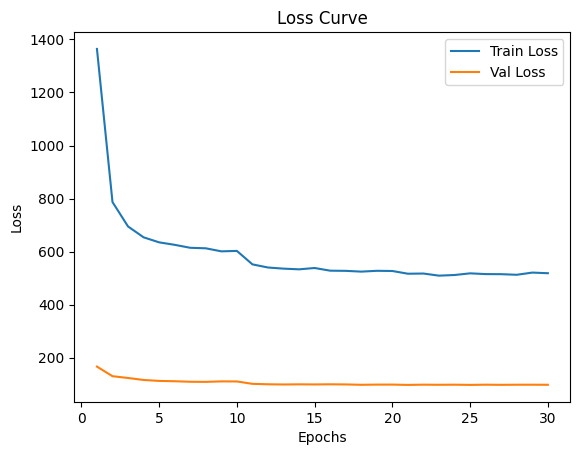

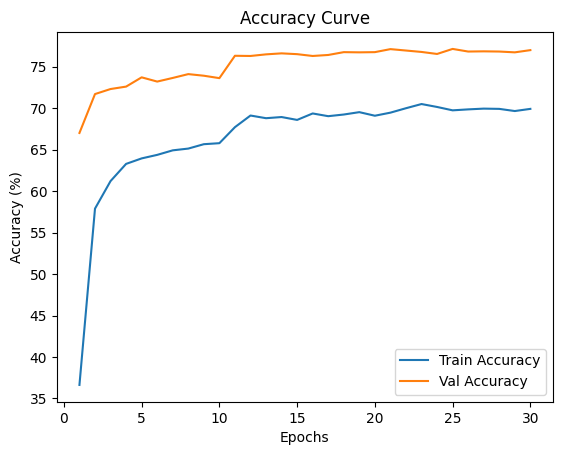

In [10]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

## Saving Results

In [11]:
%cd /kaggle/working
!ls

from IPython.display import FileLink
FileLink(r'best_model.pt')

/kaggle/working
best_model.pt  data  dog_breed_model.pt  images.tar  stanford_dogs


/kaggle/working/best_model.pt